Notebook para o cálculo de A1

In [23]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import stats
import math
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
from bar_funcs import *

In [14]:
plt.rcParams['figure.figsize'  ] = (3.4,2.0)
plt.rcParams['font.size'       ] = 8
plt.rcParams['legend.fontsize' ] = 8
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['xtick.major.width'] = 0.75
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.75
plt.rcParams['ytick.minor.width'] = 0.5

Galáxia barrada isolada ou com satélites

In [3]:
#path = 'barrada/'
path = 'satelites/sat1-30/'
paths1 = [path]

In [4]:
#n_snapshots_ = 281
n_snapshots_ = 121

In [5]:
time = np.empty(n_snapshots_)

In [14]:
%%time
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição - centro de massa
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
        
        #calcular A1
        if p == 0:
            A1, r = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

CPU times: user 33min 36s, sys: 42.9 s, total: 34min 19s
Wall time: 33min 36s


/tmp/ipykernel_3908/3494248252.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=3.0, cmap='viridis',
/tmp/ipykernel_3908/3494248252.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(tmin, tmax)


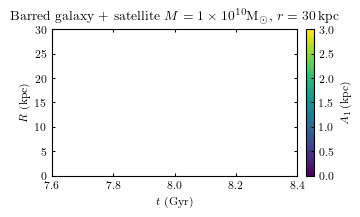

In [15]:
Qlist = []

for j in range (0, n_snapshots_):
    doc = path + 'a1/'+ f'a1-{j}.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = min(time) + 8.0
tmax = max(time) + 8.0

Rmin = 0
Rmax = 30

fig, ax = plt.subplots(nrows=1, ncols=1)
extent = [tmin, tmax, Rmin, Rmax]
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=3.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
cb.set_label(r'$A_1 \, \mathrm{(kpc)}$')

ax.set_xlabel(r'$t$ (Gyr)')
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

title = 'Barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
#title = 'Isolated barred galaxy'
ax.set_title(title)

fig.tight_layout(pad=0.1)    

#plt.savefig('testea1.png', dpi=300)

Galáxia teste sem gás

In [5]:
path = 'satelites/teste-nogas-05-20/'
paths2 = [path]

In [6]:
n_snapshots = 121

In [7]:
time = np.empty(n_snapshots)

In [38]:
%%time
for p, path in enumerate(paths2):

    for j in range (0, n_snapshots):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m=m_disk, x=vx_disk, y=vy_disk, z=vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

        #calcular A1
        if p == 0:
            A1, r = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

CPU times: user 32min 52s, sys: 22.3 s, total: 33min 14s
Wall time: 33min 18s


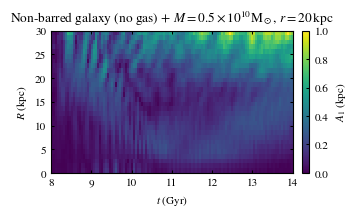

In [39]:
Qlist = []

for j in range (0, n_snapshots):
    doc = path + 'a1/'+ f'a1-{j}.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = 8
tmax = 14

Rmin = 0
Rmax = 30

# Qmin = Qlist.min()
# Qmax = Qlist.max()
   
fig, ax = plt.subplots(nrows=1, ncols=1)

extent = [tmin, tmax, Rmin, Rmax]
   
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
cb.set_label(r'$A_1$ (kpc)')

ax.set_xlabel(r'$t$ (Gyr)')
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

ax.set_title('Non-barred galaxy (no gas) + ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$')

fig.tight_layout(pad=0.1)    

plt.savefig('a1-teste-nogas.png', dpi=300)

Galáxia não barrada isolada ou com satélites

In [14]:
#path = 'n_barrada/'
path = 'satelites/nb-sat1-30/'
paths1 = [path]

In [15]:
#n_snapshots_ = 281
n_snapshots_ = 121

In [16]:
time = np.empty(n_snapshots_)

In [8]:
%%time
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e stars e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        m_disk = np.array(f_disk['Masses'])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        #corrigir posição - momento angular - disk
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                               vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
        
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                          vy=vy_new_disk, theta=theta)
       
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
        
        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            z_new_star = 0
            vx_new_star = 0
            vy_new_star = 0
            vz_new_star = 0
            
        else:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            vx_star = np.array(f_star['Velocities'][:,0])
            vy_star = np.array(f_star['Velocities'][:,1])
            vz_star = np.array(f_star['Velocities'][:,2])
            m_star = np.array(f_star['Masses'])
            Nstar = len(np.array(f_star['ParticleIDs']))

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
            vx_new_star, vy_new_star, vz_new_star = shift_com(m_star, vx_star, vy_star, vz_star)

            #corrigir posição - momento angular - stars
            theta_s, phi_s = theta_phi(N=Nstar, x=x_new_star, y=y_new_star, z=z_new_star, vx=vx_new_star,
                                       vy=vy_new_star, vz=vz_new_star, m=m_star)
        
            x_s, y_s, vx_s, vy_s = angular_momentum_1(N=Nstar, x=x_new_star, y=y_new_star, vx=vx_new_star,
                                                  vy=vy_new_star, theta=theta_s)
        
            x_s, z_s, vx_s, vz_s = angular_momentum_2(N=Nstar, x=x_s, z=z_new_star, vx=vx_s, vz=vz_new_star,
                                                          phi=phi_s)
        #juntar disk + stars
        if j == 0:
            m_tot = m_disk
            x_tot = x
            y_tot = y
            z_tot = z
            vx_tot = vx
            vy_tot = vy
            vz_tot = vz
        
        else:
            x_tot = np.concatenate((x, x_s))
            y_tot = np.concatenate((y, y_s))
            z_tot = np.concatenate((z, z_s))
            vx_tot = np.concatenate((vx, vx_s))
            vy_tot = np.concatenate((vy, vy_s))
            vz_tot = np.concatenate((vz, vz_s))
            m_tot = np.concatenate((m_disk, m_star))

        #calcular força da barra
        if p == 0:
            A1, r = A1_warp(m=m_tot, x=x_tot, y=y_tot, z=z_tot, Rmax=30.0, Nbins=30,
                            n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}-nb.txt', out, fmt='%1.6e', header=header)   

CPU times: user 58min 47s, sys: 1min 2s, total: 59min 50s
Wall time: 1h 49s


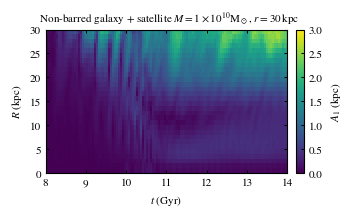

In [17]:
Qlist = []

for j in range (0, n_snapshots_):
    doc = path + 'a1/'+ f'a1-{j}-nb.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = 8
tmax = 14

Rmin = 0
Rmax = 30
   
fig, ax = plt.subplots(nrows=1, ncols=1)

extent = [tmin, tmax, Rmin, Rmax]
   
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=3.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
cb.set_label(r'$A_1$ (kpc)')

ax.set_xlabel(r'$t$ (Gyr)')
#ax.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

title = '  Non-barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
ax.set_title(title, fontsize=8)

fig.tight_layout(pad=0.1)    

plt.savefig('a1-nb-1-30.png', dpi=300)

Comparação entre orientação: theta da barra e theta do warp

In [24]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 15

In [30]:
#path = 'barrada/'
path = 'satelites/sat1-20/'
paths1 = [path]

#n_snapshots_ = 281
n_snapshots_ = 121

In [31]:
time = np.empty(n_snapshots_)
orientation_bar = np.empty(n_snapshots_)
orientation_warp = np.empty(n_snapshots_)

In [32]:
%%time
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição - centro de massa
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
        
        #calcular orientação
        if p == 0:
            orientation_bar[j] = theta_bar(m=m_disk, x=x, y=y, Rmax=10.0)
            orientation_warp[j] = theta_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Rmin=20.0)

CPU times: user 36min 47s, sys: 21.6 s, total: 37min 9s
Wall time: 37min 34s


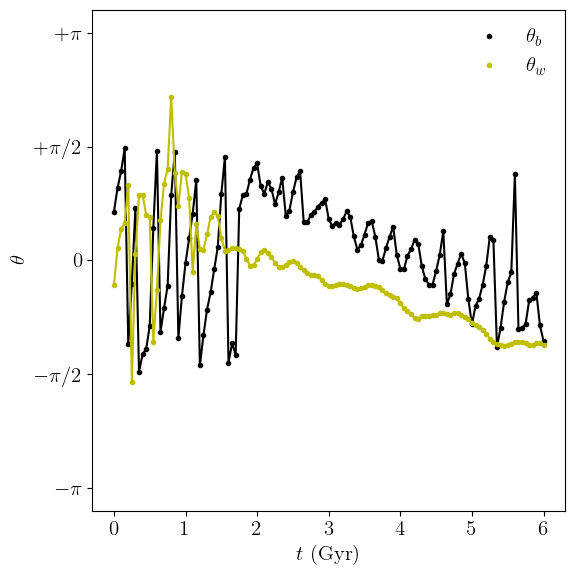

In [36]:
time_ = time + 8.0

plt.figure(figsize=[6,6])
plt.plot(time, orientation_bar, 'k.', label=r'$\theta_b$')
plt.plot(time, orientation_bar, 'k-')
plt.plot(time, orientation_warp, 'y.', label=r'$\theta_w$')
plt.plot(time, orientation_warp, 'y-')
ylims=[(-1.1) * np.pi, 1.1 * np.pi]
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.ylim(ylims)
#plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylabel(r'$\theta~$')
plt.xlabel(r'$t~({\rm Gyr})$')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f'theta-w-1-20.png')

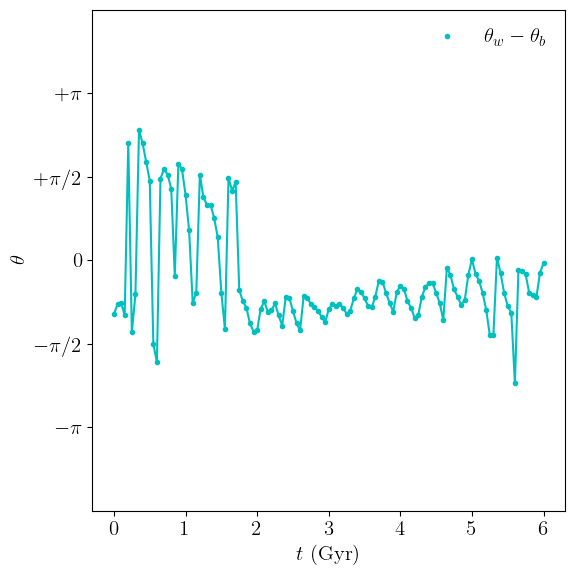

In [35]:
delta = orientation_warp-orientation_bar

plt.figure(figsize=[6,6])
plt.plot(time, delta, 'c.', label=r'$\theta_w - \theta_b$')
plt.plot(time, delta, 'c-')
ylims=[(-1.5) * np.pi, 1.5 * np.pi]
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.ylim(ylims)
#plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylabel(r'$\theta~$')
plt.xlabel(r'$t~({\rm Gyr})$')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f'theta-wb-1-20.png')